# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [58]:
#Regular EDA and plotting libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# We want our plots to appear in the notebook
%matplotlib inline

## Models
from tqdm import tqdm, trange
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import joblib
import gc

In [59]:
DATASET_DIRECTORY = 'CICIoT2023/'

In [60]:
# List all files in the directory
df_sets = [f for f in os.listdir(DATASET_DIRECTORY) if os.path.isfile(os.path.join(DATASET_DIRECTORY, f)) and f.endswith('.csv')]
df_sets.sort()
# Check if there's at least one CSV file
if df_sets:
    # Construct the full path of the first CSV file
    first_csv_file_path = os.path.join(DATASET_DIRECTORY, df_sets[0])
    
    # Read the first CSV file into a DataFrame
    df = pd.read_csv(first_csv_file_path)
    print(f"Loaded {first_csv_file_path} into DataFrame.")
else:
    print("No CSV files found in the directory.")


Loaded CICIoT2023/part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv into DataFrame.


### Importing Dataset

In [61]:
# Splitting the data into training and test sets
training_sets, test_sets = train_test_split(df, test_size=0.2, random_state=42)

In [62]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',
]
y_column = 'label'

### Scaling

In [63]:
scaler = StandardScaler()

In [64]:
# Fit the scaler to the training data's features
scaler.fit(training_sets[X_columns])

# Transform the training and test data's features
training_sets_scaled = training_sets.copy()
test_sets_scaled = test_sets.copy()
training_sets_scaled[X_columns] = scaler.transform(training_sets[X_columns])
test_sets_scaled[X_columns] = scaler.transform(test_sets[X_columns])

## Train RandomForest on the entire training data to get feature importances

In [65]:
print("Training RandomForest to get feature importances...")
rf_model = RandomForestClassifier(n_jobs=-1)

Training RandomForest to get feature importances...


In [66]:
# Train the model using the scaled training data
rf_model.fit(training_sets_scaled[X_columns], training_sets[y_column])

print("RandomForest training completed.")

RandomForest training completed.


In [67]:
feature_importances = rf_model.feature_importances_

# Displaying feature importances
for feature, importance in zip(X_columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

flow_duration: 0.0309
Header_Length: 0.0379
Protocol Type: 0.0454
Duration: 0.0039
Rate: 0.0187
Srate: 0.0163
Drate: 0.0000
fin_flag_number: 0.0232
syn_flag_number: 0.0439
rst_flag_number: 0.0174
psh_flag_number: 0.0443
ack_flag_number: 0.0104
ece_flag_number: 0.0000
cwr_flag_number: 0.0000
ack_count: 0.0292
syn_count: 0.0495
fin_count: 0.0199
urg_count: 0.0196
rst_count: 0.0225
HTTP: 0.0009
HTTPS: 0.0010
DNS: 0.0000
Telnet: 0.0000
SMTP: 0.0000
SSH: 0.0000
IRC: 0.0000
TCP: 0.0149
UDP: 0.0246
DHCP: 0.0000
ARP: 0.0000
ICMP: 0.0134
IPv: 0.0000
LLC: 0.0000
Tot sum: 0.0316
Min: 0.0481
Max: 0.0223
AVG: 0.0404
Std: 0.0055
Tot size: 0.0481
IAT: 0.2446
Number: 0.0028
Magnitue: 0.0475
Radius: 0.0058
Covariance: 0.0059
Variance: 0.0069
Weight: 0.0028


In [68]:
# Sort feature importances in descending order and get the indices
indices = np.argsort(feature_importances)[::-1]

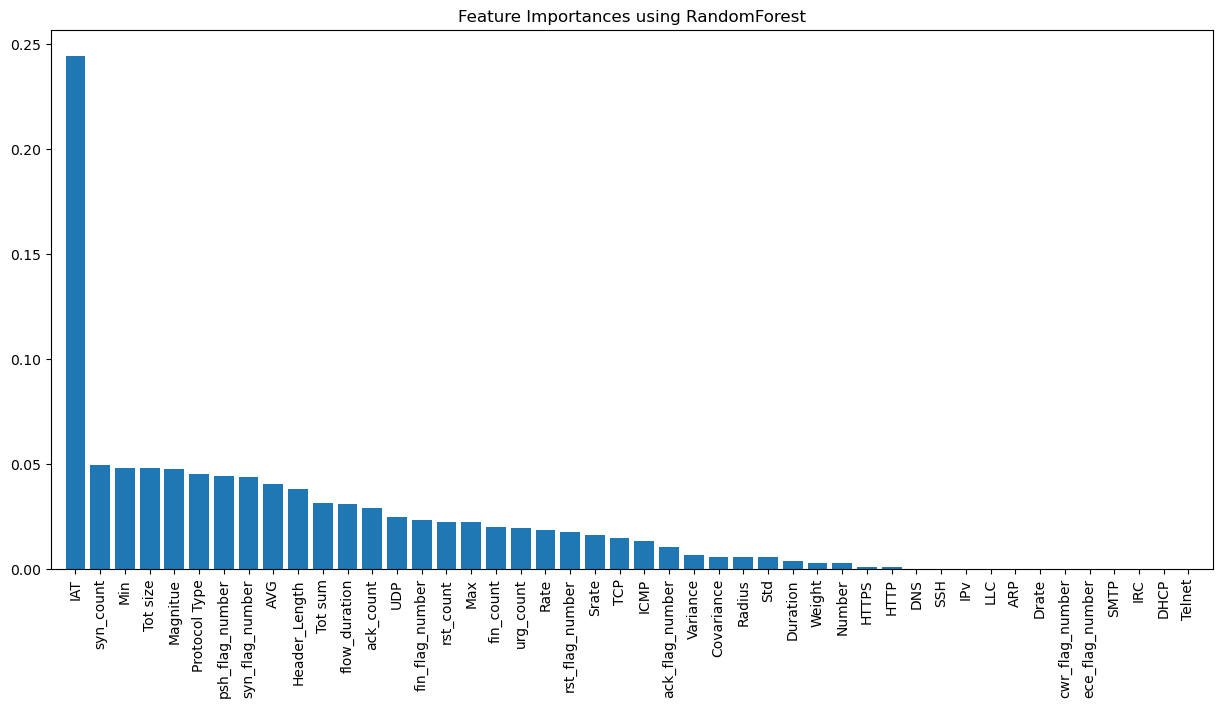

In [69]:
# Plot the feature importances
plt.figure(figsize=(15, 7))
plt.title("Feature Importances using RandomForest")
plt.bar(range(len(X_columns)), feature_importances[indices], align="center")
plt.xticks(range(len(X_columns)), [X_columns[i] for i in indices], rotation=90)
plt.xlim([-1, len(X_columns)])
plt.show()

In [70]:
# You can also select the top N features based on their importance
N = 20  # for example
top_20_features = [X_columns[i] for i in indices[:N]]
print("Top 20 features:", top_20_features)

Top 20 features: ['IAT', 'syn_count', 'Min', 'Tot size', 'Magnitue', 'Protocol Type', 'psh_flag_number', 'syn_flag_number', 'AVG', 'Header_Length', 'Tot sum', 'flow_duration', 'ack_count', 'UDP', 'fin_flag_number', 'rst_count', 'Max', 'fin_count', 'urg_count', 'Rate']


In [71]:
# Save the trained RandomForest model and top N features using joblib
print("Saving RandomForest model and top 20 features...")
joblib.dump(rf_model, "rf_model_feature_importance.sav")
joblib.dump(top_20_features, "top_20_features.sav")

Saving RandomForest model and top 20 features...


['top_20_features.sav']

# Classification: 2 (1+1) Classes

In [72]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [73]:
# Define the models
ML_models = [
    LogisticRegression(n_jobs=-1),
    Perceptron(),
    AdaBoostClassifier(),
    RandomForestClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]

# Define the model names
ML_names = [
    "LogisticRegression",
    "Perceptron",
    "AdaBoost",
    "RandomForest",
    "DecisionTree"
]

# Load RandomForest model and top N features from joblib
rf_model = joblib.load("rf_model_feature_importance.sav")
top_20_features = joblib.load("top_20_features.sav")

# Convert the labels of the training set using the dictionary
training_sets_scaled[y_column] = training_sets_scaled[y_column].map(dict_2classes)

# Train each model on the scaled training data using top N features
for i, model in enumerate(ML_models):
    model.fit(training_sets_scaled[top_20_features], training_sets_scaled[y_column])
    print(f"{ML_names[i]} has been trained using top {len(top_20_features)} features")
    
    # Save the trained model
    filename = f"rf_fi_model_2classes_{ML_names[i]}.sav"
    joblib.dump(model, filename)

# Load the trained models
#ML_models = [joblib.load(f"rf_fi_model_2classes_{name}.sav") for name in ML_names]

/home/sc/0.DCU/00.Project/ML_based_IDS_for_IoT/project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression has been trained using top 20 features
Perceptron has been trained using top 20 features
AdaBoost has been trained using top 20 features
RandomForest has been trained using top 20 features
DecisionTree has been trained using top 20 features


In [74]:
y_test = []
preds = {name: [] for name in ML_names}

# Convert the labels of the test set using the dictionary
test_sets_scaled[y_column] = test_sets_scaled[y_column].map(dict_2classes)

# Store the true labels
y_test += list(test_sets_scaled[y_column].values)

# Load models using joblib
ML_models = [joblib.load(f"rf_fi_model_2classes_{name}.sav") for name in ML_names]

# Get predictions from each model
for name, model in tqdm(zip(ML_names, ML_models), total=len(ML_names), desc="Predicting with models"):
    y_pred = list(model.predict(test_sets_scaled[top_20_features]))
    preds[name] = preds[name] + y_pred

# Save the predictions and true labels using joblib
joblib.dump(preds, "rf_fi_model_predictions.sav")
joblib.dump(y_test, "rf_fi_true_labels.sav")

Predicting with models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.45it/s]


['rf_fi_true_labels.sav']

In [75]:
# Initialize the metrics_store_2classes dictionary here
metrics_store_2classes = {}

# Loop through each model's predictions and evaluate
for name, y_pred in tqdm(preds.items(), desc="Evaluating models"):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    metrics_store_2classes[name] = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }
    print(f"##### {name} (2 classes) #####")
    print('accuracy_score: ', accuracy)
    print('recall_score: ', recall)
    print('precision_score: ', precision)
    print('f1_score: ', f1)
    print("\n" * 3)
    
# Save the metrics to a file
joblib.dump(metrics_store_2classes, "rf_fi_model_evaluation_metrics.sav")
print("Metrics saved to file.")


Evaluating models:  20%|████████████████████████                                                                                                | 1/5 [00:00<00:02,  1.70it/s]

##### LogisticRegression (2 classes) #####
accuracy_score:  0.9864678034270392
recall_score:  0.7935901464971233
precision_score:  0.8839502142778285
f1_score:  0.8324197338360859






Evaluating models:  40%|████████████████████████████████████████████████                                                                        | 2/5 [00:01<00:01,  1.55it/s]

##### Perceptron (2 classes) #####
accuracy_score:  0.9856508441912104
recall_score:  0.7482121464679604
precision_score:  0.9025414638145791
f1_score:  0.8061716150636593






Evaluating models:  60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [00:01<00:01,  1.60it/s]

##### AdaBoost (2 classes) #####
accuracy_score:  0.9958104654572877
recall_score:  0.9646808321226925
precision_score:  0.9460108172388124
f1_score:  0.9551441093911687






Evaluating models:  80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [00:02<00:00,  1.58it/s]

##### RandomForest (2 classes) #####
accuracy_score:  0.9964179479659809
recall_score:  0.9636823508916532
precision_score:  0.9584805161172629
f1_score:  0.9610659873155463






Evaluating models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]

##### DecisionTree (2 classes) #####
accuracy_score:  0.9954962503665843
recall_score:  0.9488058784570412
precision_score:  0.9523607980041446
f1_score:  0.9505759557401352




Metrics saved to file.


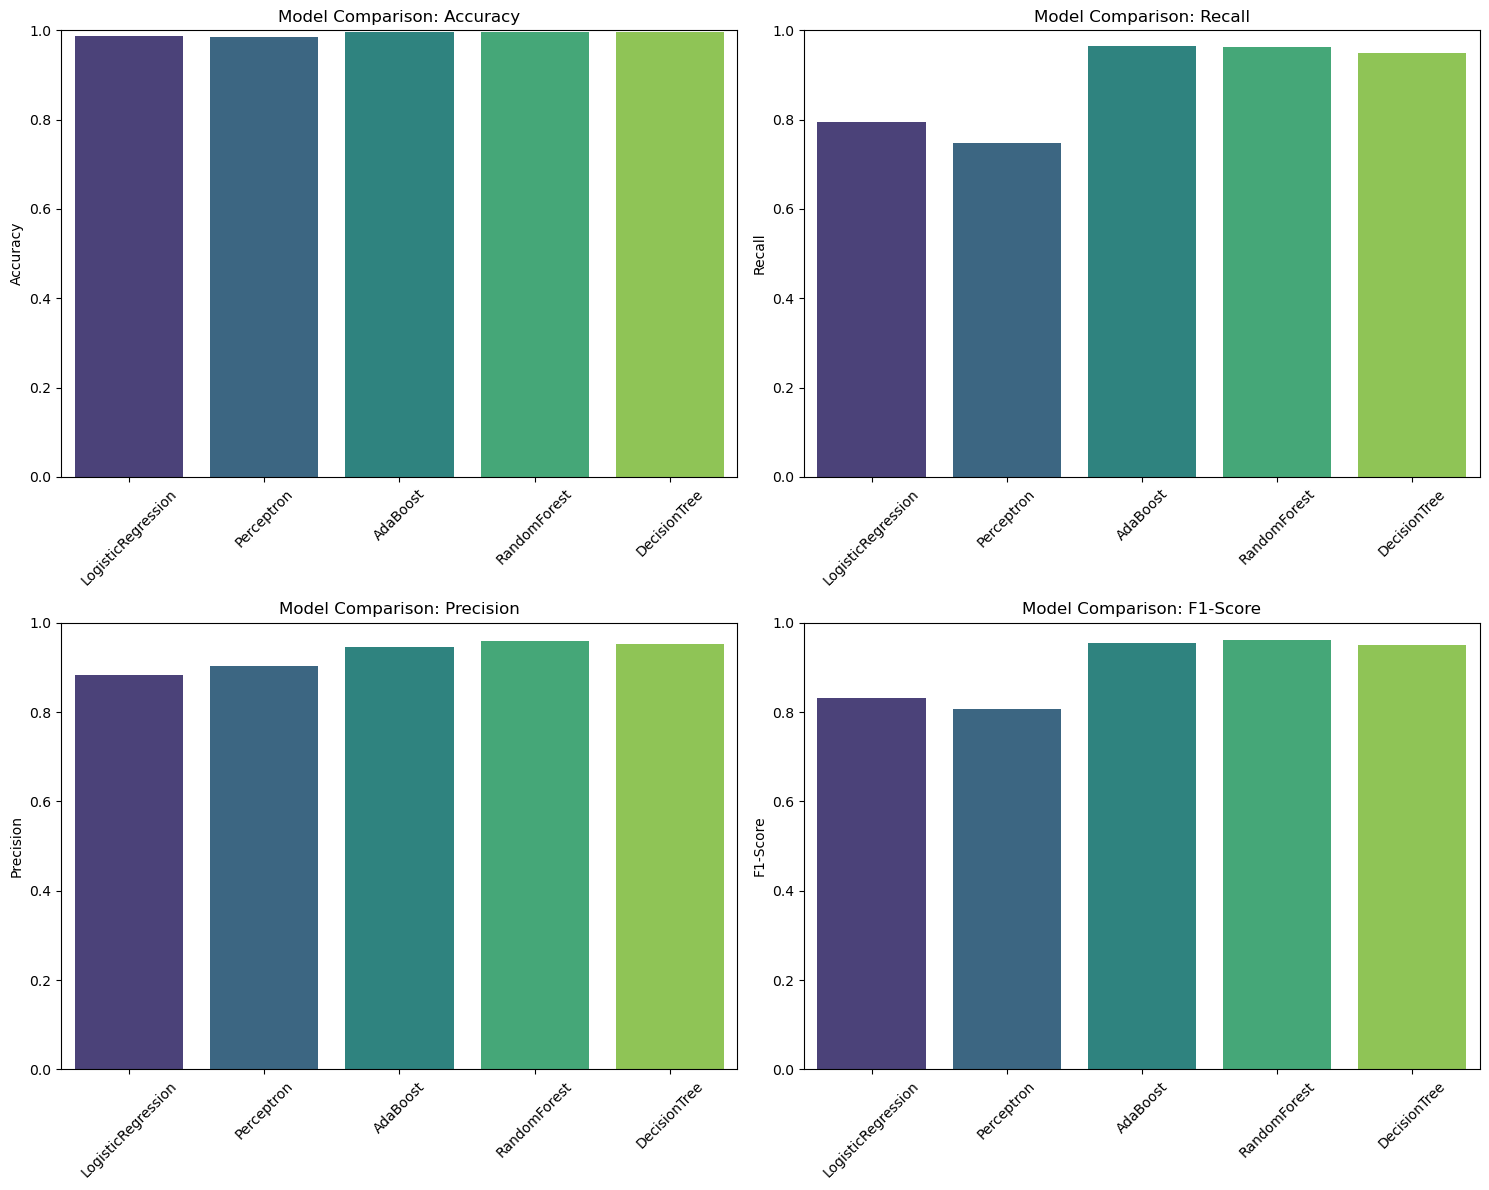

In [76]:
# Load the saved metrics from the joblib file
metrics_store_2classes = joblib.load("rf_fi_model_evaluation_metrics.sav")

# Extract metrics from the loaded data
accuracies = [metrics_store_2classes[model]['accuracy'] for model in ML_names]
recalls = [metrics_store_2classes[model]['recall'] for model in ML_names]
precisions = [metrics_store_2classes[model]['precision'] for model in ML_names]
f1_scores = [metrics_store_2classes[model]['f1'] for model in ML_names]

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Define metrics and their names for plotting
metrics = [accuracies, recalls, precisions, f1_scores]
metric_names = ['Accuracy', 'Recall', 'Precision', 'F1-Score']

# Plot each metric
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=ML_names, y=metric, palette="viridis")
    plt.title(f'Model Comparison: {metric_name}')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Since all metrics are in the range [0, 1]

plt.tight_layout()
plt.show()


In [77]:
del preds

In [78]:
del y_test

In [107]:
# Assuming you've already loaded the necessary libraries and defined the scaler, ML_models, and other necessary variables

# Load the second (unknown) CSV file
unknown_csv_path = os.path.join(DATASET_DIRECTORY, df_sets[1])
unknown_df = pd.read_csv(unknown_csv_path)
print(f"Loaded {unknown_csv_path} into DataFrame.")

Loaded CICIoT2023/part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv into DataFrame.


In [108]:
# Preprocess the data
# Convert the labels using the dictionary (if the labels are present in the unknown dataset)
if y_column in unknown_df.columns:
    unknown_df[y_column] = unknown_df[y_column].map(dict_2classes)

In [109]:
# Scale the features
unknown_df_scaled = unknown_df.copy()
unknown_df_scaled[X_columns] = scaler.transform(unknown_df[X_columns])

In [110]:
# Make predictions using the trained models
predictions = {}
for name, model in zip(ML_names, ML_models):
    y_pred = model.predict(unknown_df_scaled[top_20_features])
    predictions[name] = y_pred

In [111]:
if y_column in unknown_df.columns:
    for name in ML_names:
        accuracy = accuracy_score(unknown_df[y_column], predictions[name])
        recall = recall_score(unknown_df[y_column], predictions[name], average='macro')
        precision = precision_score(unknown_df[y_column], predictions[name], average='macro')
        f1 = f1_score(unknown_df[y_column], predictions[name], average='macro')
        
        print(f"##### {name} on unknown data #####")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("\n")


##### LogisticRegression on unknown data #####
Accuracy: 0.9867
Recall: 0.7955
Precision: 0.8917
F1-Score: 0.8365


##### Perceptron on unknown data #####
Accuracy: 0.9855
Recall: 0.7519
Precision: 0.8999
F1-Score: 0.8083


##### AdaBoost on unknown data #####
Accuracy: 0.9962
Recall: 0.9673
Precision: 0.9525
F1-Score: 0.9598


##### RandomForest on unknown data #####
Accuracy: 0.9967
Recall: 0.9627
Precision: 0.9656
F1-Score: 0.9642


##### DecisionTree on unknown data #####
Accuracy: 0.9956
Recall: 0.9500
Precision: 0.9538
F1-Score: 0.9519




In [ ]:
# Load the earlier metrics
earlier_metrics = joblib.load("rf_fi_model_evaluation_metrics.sav")

if y_column in unknown_df.columns:
    for name in ML_names:
        # Compute metrics for unknown data
        accuracy = accuracy_score(unknown_df[y_column], predictions[name])
        recall = recall_score(unknown_df[y_column], predictions[name], average='macro')
        precision = precision_score(unknown_df[y_column], predictions[name], average='macro')
        f1 = f1_score(unknown_df[y_column], predictions[name], average='macro')
        
        # Extract earlier metrics for the model
        earlier_accuracy = earlier_metrics[name]['accuracy']
        earlier_recall = earlier_metrics[name]['recall']
        earlier_precision = earlier_metrics[name]['precision']
        earlier_f1 = earlier_metrics[name]['f1']

        # Display the comparison
        print(f"##### {name} #####")
        print(f"Earlier Accuracy vs Unknown Data Accuracy: {earlier_accuracy:.4f} vs {accuracy:.4f}")
        print(f"Earlier Recall vs Unknown Data Recall: {earlier_recall:.4f} vs {recall:.4f}")
        print(f"Earlier Precision vs Unknown Data Precision: {earlier_precision:.4f} vs {precision:.4f}")
        print(f"Earlier F1-Score vs Unknown Data F1-Score: {earlier_f1:.4f} vs {f1:.4f}")
        print("\n")
